In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using device: cpu
img_size (128, 128) patch_size (8, 8) frames 12 t_patch_size 3
torch.Size([1, 12, 128, 128])
Inference time: 4.491 seconds
(128, 128)


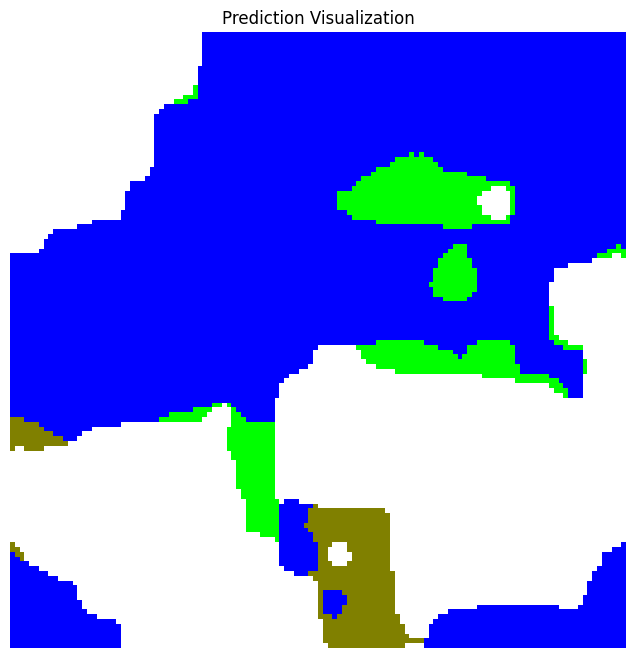

In [4]:
import os
import time
import json
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import skimage.io as io
import matplotlib.pyplot as plt

from src.models_vit_tensor_CD_2 import vit_base_patch8


def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()


def open_image(img_path):
    img = io.imread(img_path).astype(np.float32)
    return img


def preprocess_image(img):
    b = np.mean(img, axis=2, keepdims=True)
    img = np.concatenate((img, b, b), axis=2)

    kid = img - img.min(axis=(0, 1), keepdims=True)
    mom = img.max(axis=(0, 1), keepdims=True) - img.min(axis=(0, 1), keepdims=True) + 1e-10
    img = kid / mom

    transform = transforms.ToTensor()
    return transform(img).unsqueeze(0)  # Add batch dim




def visualize_mask(mask, palette):
    color_mask = Image.fromarray(mask, mode="P")
    color_mask.putpalette(palette)

    plt.figure(figsize=(8, 8))
    plt.imshow(color_mask)
    plt.axis('off')
    plt.title("Prediction Visualization")
    plt.show()


def main(image_path):
    # ----- Paths -----
    weights_path = "checkpoint/model_multi_0.pth"
    palette_path = "checkpoint/palette.json"

    # ----- Checks -----
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    assert os.path.exists(weights_path), f"Model weights not found: {weights_path}"
    assert os.path.exists(palette_path), f"Palette file not found: {palette_path}"

    with open(palette_path, "r") as f:
        palette_dict = json.load(f)
        palette = [v for sublist in palette_dict.values() for v in sublist]

    # ----- Device & Model -----
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = vit_base_patch8(num_classes=13)
    model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=False)['model'])
    model.to(device)
    model.eval()

    # ----- Load and preprocess -----
    img = open_image(image_path)
    input_tensor = preprocess_image(img).to(device)
    print(input_tensor.shape)

    # ----- Inference -----
    with torch.no_grad():
        t0 = time_synchronized()
        output = model(input_tensor)
        t1 = time_synchronized()
        print(f"Inference time: {t1 - t0:.3f} seconds")

        prediction = output['out'].argmax(1).squeeze(0).cpu().numpy().astype(np.uint8)
        print(prediction.shape)
        # mapped_pred = map_prediction(prediction)

    # ----- Visualize -----
    visualize_mask(prediction, palette)


if __name__ == '__main__':
    # Example usage
    test_image_path = "SegMunich_train_img_10.tif"  # Replace with your test image
    main(test_image_path)
